# initial notebook for connectivity using gdal_proximity
- needs xarray-spatial, not avaliable in datacube
- can make venvs, but for below just cloned repo (https://github.com/makepath/xarray-spatial/tree/master)
- binary layers of wofs, items, mangrove, saltmarsh, saltflats, stream network
- buffers to tile by double then does proximity analysis and cuts back to original bounds of tile
- this needs to be done as we had issues with tile boundaries

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()


sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [3]:
# GA coastal tiles
# vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
vector_file = '../data/geojson/ga_summary_grid_c3_mainland_extended.gpkg'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

In [4]:
gdf = mainland_grid.loc[mainland_grid['id'] == 334]

In [5]:
gdf.explore()

In [6]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

query_buffered = {
    "time": time_range,
    'resolution':res}

In [7]:
# Function to buffer a geometry by a factor of two (for running proximity analysis on a greater area before cutting to tile size)
def double_buffer(geometry):
    return geometry.buffer(distance=0.5)  # Buffer by 0.5 to double the size

# Apply the double_buffer function to the geometry column
gdf['doubled_geometry'] = gdf['geometry'].apply(double_buffer)

/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Extract the feature's doubled geometry as a datacube geometry object
    geom = Geometry(geom=row.doubled_geometry, crs=gdf.crs)
    
    # Update the query to include our doubled geopolygon
    query_buffered.update({'geopolygon': geom})
    
    
# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}
query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
       & {'resolution', 'geopolygon'}}
    
geometry = query_notime['geopolygon'].geom
bbox = geometry.bounds   

# need this to load streams (as gdf needs bounds)
geometry = query_buffered_notime['geopolygon'].geom
doubled_bbox = geometry.bounds

Feature: 233/1


In [9]:
%%time
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_buffered_notime)
srtm = srtm_ds.dem_h
# for connectivity model less than 10m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
AHD_min = -6
AHD_max = 10
# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan0m_AHD = srtm >= AHD_min
# srtm_mask = lessthan10m_AHD
srtm_mask = lessthan10m_AHD & greaterthan0m_AHD

# Load SRTM tile bounds for masking at the end
srtm_ds_tile = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm_tile = srtm_ds_tile.dem_h
tile = xr.DataArray(np.ones_like(srtm_tile), coords=srtm_tile.coords, dims=srtm_tile.dims, attrs=srtm_tile.attrs)

# Load in water from wofs
wofs = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query_buffered)
# get water class
water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')

# Load ITEMs
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_buffered_notime)
item = item_ds.relative
intertidal = (item >= 2) & (item <= 8)


# Load in mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query_buffered)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# Load in saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltmarsh.attrs['crs'] = 'EPSG:3577'


# Load in saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltflat.attrs['crs'] = 'EPSG:3577'


# Load in Geofabric mapped stream
streams_gdf = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/Geofabric/AHGFMappedStream.shp', bbox=doubled_bbox)
streams_mask = xr_rasterize(streams_gdf, srtm_ds)

CPU times: user 29.6 s, sys: 4.86 s, total: 34.4 s
Wall time: 2min 9s


In [10]:
# remove time dim on some vars
water = water.squeeze('time')
intertidal = intertidal.squeeze('time')
mangrove = mangrove.squeeze('time')
srtm_mask = srtm_mask.squeeze('time').astype('int8')

In [11]:
# combine masks
aquatic = xr.where((water == True) | (intertidal == True) | 
                   (mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (streams_mask == True), 1, 0).astype('int8')

In [12]:
# xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
# seems it is in same units as crs (EPSG3577 = metres)
proximity_agg = proximity(aquatic)

# mask with srtm_mask (need to do before normalisation so that min and max are within bounds of 0-10m elevation)
proximity_agg_mask = proximity_agg.where(srtm_mask)

In [13]:
# Find the minimum and maximum values in the data array - taking a percentile just to ensure any extreme odd values are not considered
min_value = np.nanpercentile(proximity_agg_mask, 0.01)
max_value = np.nanpercentile(proximity_agg_mask, 99.99)
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Clip values above max_value percentile
# proximity_agg_mask = xr.where(np.isnan(proximity_agg_mask), proximity_agg_mask, np.minimum(proximity_agg_mask, max_value))
proximity_agg_mask = xr.where(proximity_agg_mask >= max_value, max_value, proximity_agg_mask.values)

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
proximity_norm = (proximity_agg_mask - min_value) / (max_value - min_value)

# invert the normalisation to make connectivity layer output
connectivity = (1 - proximity_norm)

# removing water, mangroves and items from connectivity output #
# not water == True
not_water = (1 - water)
not_water = not_water == 1

# not exposed intertidal == True
not_intertidal = (1 - intertidal)

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# combine masks
# where its not mangrove or exposed intertidal
combine_not_masks = xr.where((not_water == True) & (not_intertidal == True) & (not_mangrove == True) , 1, np.nan)

# remove areas that would not be supratidal forest connectivity (i.e. water bodies and mangroves to np.nan)
connectivity_mask = connectivity * combine_not_masks

# select out connectivity area for bounds of original tile
connectivity_tile = connectivity_mask * tile

Minimum Value: 0.0
Maximum Value: 1477.32861328125


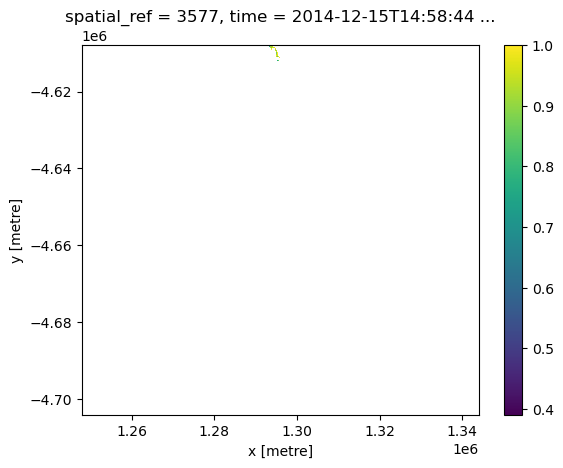

In [14]:
connectivity_tile.plot()

In [ ]:
# export
if export == False:
        pass
else:
    write_cog(geo_im=connectivity_mask,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_mask_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)
    write_cog(geo_im=connectivity_tile,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_tile_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)